# Introduction to Yelp Review Sentiment Classification

In this project, I will build a classifier that can predict how a user feels (positively or negatively) about a given restaurant from their review. This is an example of **sentiment analysis**: being able to quantify an individual's opinion about a particular topic merely from the words they use.


In this notebook, I'll:


*   Explore the Yelp review dataset
*   Preprocess and vectorize our text data for NLP
*   Train a sentiment analysis classifier with logistic regression





![Example of a Yelp review](https://drive.google.com/uc?export=view&id=1uIjM2_IR0xEXnSuO34fC44hDvXMJYMLg)

In [ ]:
#@title Import our libraries (this may take a minute or two)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import spacy
import wordcloud
import os
import sys
pd.options.mode.chained_assignment = None #suppress warnings

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from spacy.lang.en.stop_words import STOP_WORDS
nltk.download('wordnet')
nltk.download('punkt')

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!python -m spacy download en_core_web_md
import en_core_web_md
text_to_nlp = spacy.load('en_core_web_md')



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


2024-01-22 11:08:23.332504: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-22 11:08:23.332590: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-22 11:08:23.334640: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-22 11:08:26.012673: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 15.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
#@title Import our data

!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket/yelp_final.csv"

# If you run into any errors please uncomment and load the dataset below:
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%201%20-%205/Session%203%20-%20NLP/yelp_final.csv"


yelp_final.csv.1    100%[===================>] 743.14K  --.-KB/s    in 0.005s  


# Data Exploration

First we read in the file containing the reviews and take a look at the data available to us.

In [ ]:
# read our data in using 'pd.read_csv('file')'
yelp_full = pd.read_csv('yelp_final.csv')
yelp_full.head()

,business_id,stars,text,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,5,My wife took me here on my birthday for breakf...,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,5,I have no idea why some people give bad review...,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,_1QQZuf4zZOyFCvXc0o6Vg,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",uZetl9T0NcROGOyFfughhg,1,2,0
3,6ozycU1RpktNG2-1BroVtw,5,General Manager Scott Petello is a good egg!!!...,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0
4,zp713qNhx8d9KCJJnrw1xA,5,Drop what you're doing and drive here. After I...,wFweIWhv2fREZV_dYkz_1g,7,7,4


**Discuss:**
- Which column gives us our output: the user's sentiment?
- Which column gives us our input: the review?
- Why aren't businesses' and users' real names included? (You'll notice they're replaced with random strings through [hashing](https://medium.com/tech-tales/what-is-hashing-6edba0ebfa67)). Why aren't the real names included?

Let's keep only the two columns we need:



In [ ]:
needed_columns = ['stars', 'text']
yelp = yelp_full[needed_columns]
yelp.head()

,stars,text
0,5,My wife took me here on my birthday for breakf...
1,5,I have no idea why some people give bad review...
2,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!..."
3,5,General Manager Scott Petello is a good egg!!!...
4,5,Drop what you're doing and drive here. After I...


The text column is the one we are primarily focused with. Let's take a look at a few of these reviews to better understand our problem.

In [ ]:
#@title Check out the text in differently rated reviews
num_stars =  2#@param {type:"integer"}

for t in yelp[yelp['stars'] == num_stars]['text'].head(20).values:
    print (t)

Was it worth the 21$ for a salad and small pizza? Absolutely not! Bad service. Maybe the guys grandma died I don't know. I want to tell you what really made me mad about the experience. We order the small pizza and salad and the guys could have cared less and took our $ and we sat down. We were looking around and hmm, there's a sign saying "x large pizza and large salad only 23$". Wow that would have been nice if the guy told us that. I left hungry, mad and unsatisfied. 

To the owner: teach your employees the value of upselling and telling the specials. Something so small can affect a customers experience negatively. 

And your salads are severely overpriced 

Won't go back unless I'm desperate.
I have to add to Andrew's review.....

I just can't believe the things that happened!!

Yes the app was good.  The entree was good too, but there were bites of just bread with no chicken in the panini.  It definitely would have been better with more chicken!

But the girl working here is one o

**Discuss:**


*   What words are often used in highly rated reviews?
*   What words are often used in low-rated reviews?
*   Do you notice any interesting exceptions? (For example, "The seating and ambience were impressive, but the food served to us was not")


#### Word Clouds

Another way to take a look at the most prominent words in any given star rating is through the use of word clouds.

Edit the value in the cell below to see the word cloud for each star rating.

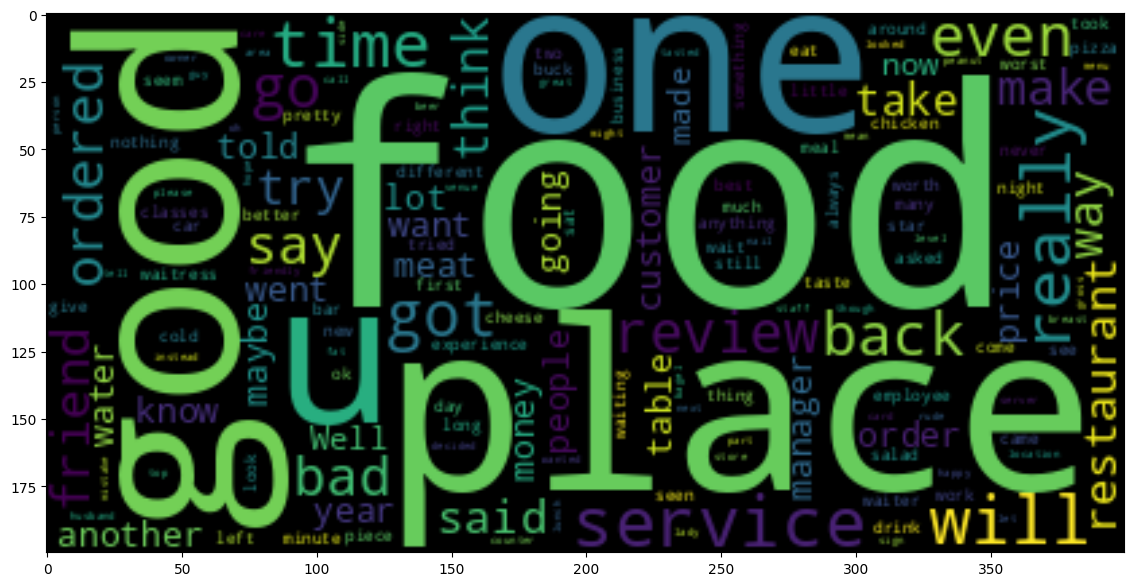

In [ ]:
#@title Word cloud for differently rated reviews
num_stars =  1#@param {type:"integer"}
this_star_text = ''
for t in yelp[yelp['stars'] == num_stars]['text'].values: # form field cell
    this_star_text += t + ' '

wordcloud = WordCloud()
wordcloud.generate_from_text(this_star_text)
plt.figure(figsize=(14,7))
plt.imshow(wordcloud, interpolation='bilinear')

**What are the differences between the reviews that have 1, 2, 3, 4, and 5 stars?**

Any surprising similarities?


### Exercise: Rules for Sentiment Analysis

Can you think of any combinations of words, or rules, that would indicate if a particular review is **positive** or **negative**? Note them down below:




In [ ]:
#@title Rules
rule_1 = "" #@param {type:"string"}
rule_2 = "" #@param {type:"string"}
rule_3 = "" #@param {type:"string"}

**Discuss: will rules like this work well?**



# Preparing Our Data for Machine Learning

Of course, it's much more efficient to use machine learning to analyze our text than try to create rules by hand!

We'll need to prepare our data to use logistic regression. First, let's prepare our output column:

### Exercise: Preparing to Classify
We're going to try to predict the sentiment - **positive** or **negative** - based on a review's text.

In order to reduce our problem to a **binary classification** (two classes) problem, we will:

 - label 4 and 5 star reviews as 'good'
 - label 1, 2, 3 star reviews as 'bad'

Please complete the function below and run it to create a new `is_good_review` column!

In [ ]:
def is_good_review(num_stars):
    if num_stars >= 4: ### YOUR CODE HERE
        return True
    else:
        return False

# Change the stars column to either be 'good' or 'bad'.
yelp['is_good_review'] = yelp['stars'].apply(is_good_review)
yelp.head()

,stars,text,is_good_review
0,5,My wife took me here on my birthday for breakf...,True
1,5,I have no idea why some people give bad review...,True
2,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",True
3,5,General Manager Scott Petello is a good egg!!!...,True
4,5,Drop what you're doing and drive here. After I...,True


## Text Preprocessing: A Preview

Now, the trickier part: preparing our text input.

We'll need a few steps to preprocess our text and represent it numerically. **Why do we need to represent our text as numbers?**

We'll talk through all the steps here, then use a single function to implement them.

## Tokenization

First of all, we would like to **tokenize** each review: convert it from a single string into a list of words. Enter some example text into the cell below to see the tokenized version.

In [ ]:
#@title Basic tokenization example
example_text = "All the people I spoke to were super nice and very welcoming." #@param {type:"string"}
tokens = word_tokenize(example_text)
tokens

['All',
 'the',
 'people',
 'I',
 'spoke',
 'to',
 'were',
 'super',
 'nice',
 'and',
 'very',
 'welcoming',
 '.']

## Stopwords

Next, let's remove **stopwords**: words which are there to provide grammatical structure, but don't give us much information about a review's sentiment.

Edit the cell below to see if we're considering a given word as a stopword! Do you agree with the results?

In [ ]:
#@title Check if a word is a stop word
example_word = "" #@param {type:'string'}
if example_word.lower() in STOP_WORDS:
  print ('"' + example_word + '" is a stop word.')
else:
  print ('"' + example_word + '" is NOT a stop word.')

"welcoming" is NOT a stop word.


We're going to remove these stopwords from the user reviews.

Tokenization and removal of stop words are universal to nearly every NLP application. In some cases, additional cleaning may be required (for example, removal of proper nouns, removal of digits) but we can build a text preprocessing function with these "base" cleaning steps.

Putting all these together, we can come up with a text cleaning function that we can apply to all of our reviews.

## Vectors

Finally, we'll need to convert our text to **vectors**, or lists of numbers. We'll start off doing this with Bag of Words, but we'll talk about another approach later!


### Bag of Words

In a **bag of words** approach, we count how many times each word was used in each review.

Suppose we want to represent two **reviews**:
- "The food was great. The ambience was also great."
- "Great ambience, but not great food!"

First we define our vocabulary. This is *each unique word* in the review. So our **vocabulary** is:
- [also, ambience, but, food, great, not, the, was].

Next, we count up how many times each word was used! (You can also think of this as adding up one-hot encodings.)

Our reviews are encoded as:
- **First review:** [1, 1, 0, 1, 2, 0, 2, 2]. Can you explain why?
- **Second review:** [0, 1, 1, 1, 2, 1, 0, 0] Fill it in here!



## Preprocessing Our Text in Action

Let's use bag-of-words to prepare our data!

First, let's select our input *X* and output *y*:

In [ ]:
X_text = yelp['text']
y = yelp['is_good_review']

Now, let's prepare our data! First, we'll use CountVectorizer, a useful tool from Scikit-learn, to:
*   Tokenize our reviews
*   Remove stopwords
*   Prepare our vocabulary


In [ ]:
#@title Initialize the text cleaning function { display-mode: "form" }
def tokenize(text):
    clean_tokens = []
    for token in text_to_nlp(text):
        if (not token.is_stop) & (token.lemma_ != '-PRON-') & (not token.is_punct): # -PRON- is a special all inclusive "lemma" spaCy uses for any pronoun, we want to exclude these
            clean_tokens.append(token.lemma_)
    return clean_tokens


The cell below will take a moment! **Can you guess what `max_features` is for?**


In [ ]:
bow_transformer = CountVectorizer(analyzer=tokenize, max_features=800).fit(X_text)

Now, we can see our entire vocabulary! Can you guess what the numbers represent?

In [ ]:
bow_transformer.vocabulary_

{'wife': 781,
 'take': 702,
 'birthday': 101,
 'breakfast': 117,
 'excellent': 263,
 ' ': 2,
 'perfect': 524,
 'sit': 643,
 'outside': 506,
 'waitress': 763,
 'food': 302,
 'arrive': 67,
 'quickly': 568,
 'busy': 128,
 'Saturday': 43,
 'morning': 467,
 'look': 422,
 'like': 410,
 'place': 535,
 'fill': 290,
 'pretty': 554,
 'early': 245,
 'well': 778,
 '\n\n': 1,
 'simply': 641,
 'good': 328,
 'sure': 696,
 'use': 746,
 'ingredient': 382,
 'fresh': 308,
 'order': 503,
 'amazing': 62,
 'menu': 454,
 'white': 779,
 'egg': 249,
 'vegetable': 752,
 'tasty': 705,
 'delicious': 222,
 'come': 173,
 '2': 14,
 'piece': 533,
 'bread': 115,
 'absolutely': 54,
 'meal': 447,
 'toast': 720,
 'wait': 761,
 'idea': 376,
 'people': 522,
 'bad': 82,
 'review': 593,
 'go': 327,
 'probably': 558,
 'case': 139,
 'friend': 311,
 'pm': 543,
 'past': 517,
 'Sunday': 46,
 'think': 714,
 'evening': 260,
 'seat': 616,
 'say': 611,
 'girl': 323,
 'waiter': 762,
 'get': 321,
 'drink': 241,
 'pleasant': 539,
 'serv

The number represents the **index** (alphabetical position) of a word in the vocabulary.

By the way, how many words do we have?


In [ ]:
len(bow_transformer.vocabulary_)

800

It's the same as `max_features`! Is that a coincidence? What's the point of `max_features`?

Now that our vocabulary is ready, we can **transform** each review into a bag of words.



In [ ]:
X = bow_transformer.transform(X_text)

Finally, we've converted our reviews to numerical data that we can use in a logistic regression!

We can see what `X` looks like by printing it out as a DataFrame. **How long is each review's vector?** Why?

In [ ]:
pd.DataFrame(X.toarray())

,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
0,0,3,8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,3,18,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,2,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
996,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,11,0,0,0,0,0,1,0,0,...,2,0,1,0,1,0,1,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Creating a Baseline Classifier

Now, back to our sentiment analysis problem! Our data is ready for machine learning.

Our classification problem is a classic two-class classification problem, and so we will use the tried-and-tested **Logistic Regression** machine learning model.

As always, we'll start by setting aside testing and training data:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

###Exercise: Training your Model
Now, we can create and train our model! Please **fill in the code to train (or *fit*) your model**.

(Need a hint? Refer to last time's notebook or Scikit-learn documentation if needed.)

In [ ]:
logistic_model = LogisticRegression()

logistic_model.fit(X_train, y_train)

LogisticRegression()

###Exercise: Testing Your Model
Now, let's evaluate our model's accuracy! Your model needs to **predict** the sentiment, and then you'll **calculate the accuracy** using `accuracy_score`. **Which dataset** should you use?

In [ ]:
y_pred = logistic_model.predict(X_test)
accuracy = logistic_model.score(X_test, y_test)
print (accuracy)

0.755


Congratulations - you've trained and tested your model! It's not perfect, but a whole lot better than a coin flip :)


###Exercise: Trying Out Reviews

Accuracy only tells us so much! It's often useful to figure out **what sorts** of mistakes your model makes.

Try enterning some reviews below and explore:

*   What kind of reviews does your model classify correctly? For example, do long or short reviews work better?
*   What kind of reviews does your model get wrong? Does it understand sarcasm or other "tricky" language?
*   Does it seem like your model pays attention to particular words?



In [ ]:
example_review = "the food is  very  nice" #@param {type:'string'}
prediction = logistic_model.predict(bow_transformer.transform([example_review]))

if prediction:
  print ("This was a GOOD review!")
else:
  print ("This was a BAD review!")



This was a GOOD review!
